In [22]:
# !pip install seaborn


In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats
import itertools
import json

# Import data
- all thresholds: df_both_sessions

In [24]:
df_both_sessions_raw = pd.read_csv('tidy_both_sessions_thresholds_per_trial_log.csv')

# Data cleaning

In [25]:
df_both_sessions = df_both_sessions_raw.copy()

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35
- rsvp: numTrialsSent < 24
- ordinary reading: accuracy < 60
- questSD > 1 doesn't apply with the changing number of trials

In [26]:
# # num_trials_required = 23  # 23 trials for short staircase
# num_trials_required = 35  # 35 trials for original staircase

# acuity_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(acuity_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "acuity")
#         & (df_both_sessions["prolificID"].isin(acuity_low_trial_ids))
#     )
# ].copy()

# # num_trials_required = 23  # 23 trials for short staircase
# num_trials_required = 35  # 35 trials for original staircase

# crowding_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(crowding_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "crowding")
#         & (df_both_sessions["prolificID"].isin(crowding_low_trial_ids))
#     )
# ].copy()

# # num_trials_required = 16  # 16 trials for short staircase
# num_trials_required = 24  # 24 trials for original staircase

# rsvp_low_trial_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < num_trials_required),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "rsvp")
#         & (df_both_sessions["prolificID"].isin(rsvp_low_trial_ids))
#     )
# ].copy()

# reading_low_accuracy_ids = (
#     df_both_sessions.loc[
#         df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
#         "prolificID"
#     ]
#     .unique()
# )
# print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


# df_both_sessions = df_both_sessions[
#     ~(
#         (df_both_sessions["taskName"] == "reading")
#         & (df_both_sessions["prolificID"].isin(reading_low_accuracy_ids))
#     )
# ].copy()

## Filter participants who we want to exclude in the final analysis

In [27]:
# import participant lists from file
with open("exclude_dict.json", "r") as f:
    exclude_dict = json.load(f)


for task, exclude_ids in exclude_dict.items():
    df_both_sessions = df_both_sessions[
        ~(
            (df_both_sessions["taskName"] == task)
            & (df_both_sessions["prolificID"].isin(exclude_ids))
        )
    ]


## Filter data that we want to include in the analysis and pivot

In [28]:
df_for_analysis = df_both_sessions.copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["repeat"].isin([3, 4]))
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "acuity")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "crowding")
        & (df_for_analysis["meridian"] == "L8")
    )
].copy()

df_for_analysis = df_for_analysis[
    ~(
        (df_for_analysis["taskName"] == "reading")
        & (df_for_analysis["meridian"] == "second")
    )
].copy()

df_for_analysis = df_for_analysis[['prolificID', 'taskName', 'repeat', 'trial_index', 'threshold']]

display(df_for_analysis)

,prolificID,taskName,repeat,trial_index,threshold
145,5f0788c06b220f03231666a0,acuity,1,1,0.602060
146,5f0788c06b220f03231666a0,acuity,1,2,0.602060
147,5f0788c06b220f03231666a0,acuity,1,3,-0.167358
148,5f0788c06b220f03231666a0,acuity,1,4,-0.684495
149,5f0788c06b220f03231666a0,acuity,1,5,-1.030995
...,...,...,...,...,...
82050,5d7bde81c7390f00169b2fdf,reading,2,2,2.580441
82053,5f98099d48060d0450394002,reading,2,2,2.385172
82054,5f98099d48060d0450394002,reading,2,2,2.385172
82057,5fb281433a31c686f0ec3ecb,reading,2,2,2.693567


In [29]:
df_wide = (
    df_for_analysis
    .pivot_table(index=["prolificID", "taskName", "trial_index"],
                 columns="repeat",
                 values="threshold")
    .reset_index()
)
df_wide.columns.name = None
df_wide = df_wide.rename(columns=lambda x: f"repeat{x}" if isinstance(x, (int, float)) else x)

display(df_wide)

,prolificID,taskName,trial_index,repeat1,repeat2
0,559ad287fdf99b219a612d22,acuity,1,0.602060,0.602060
1,559ad287fdf99b219a612d22,acuity,2,0.602060,0.602060
2,559ad287fdf99b219a612d22,acuity,3,-0.167358,-0.167358
3,559ad287fdf99b219a612d22,acuity,4,-0.684495,-0.684495
4,559ad287fdf99b219a612d22,acuity,5,0.030174,-0.014603
...,...,...,...,...,...
13088,67fffee26ec983c07f3a2abd,acuity,34,-0.410298,-0.537715
13089,67fffee26ec983c07f3a2abd,acuity,35,-0.417214,-0.544063
13090,67fffee26ec983c07f3a2abd,acuity,36,-0.423829,-0.530340
13091,67fffee26ec983c07f3a2abd,reading,2,NaN,2.293223


## Exclude participants with high test-retest ratio
I decided to not use test-retest ratio to exclude participants here:
- Given that each participant has many test and retest thresholds (one for each trial), it is quite often that one participant get at least one large test-retest ratio, for one of the thresholds
- If I exclude people with at least 1 test-retest ratio, I would be excluding hundreds of participants
- If I exclude individual thresholds rather than people, then I have different samples for every threshold which might also be tricky to interpret?
- This doesn't affect acuity and crowding much, but affected RSVP reading a lot. The r(test,retest) decreased from 0.85 (after exclusion by ratio) to 0.5 (without exclusion by ratio)

In [30]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log10(block2 / block1)
    Since the data are already log-transformed, the results would be equivalent to:
    block2 - block1
	'''
	return df[block2_colname] - df[block1_colname]

def flag_outliers_IQR(
    df,
    col_prefix="log_ratio",
    criterion_k=1.5,
    verbose=True,
):
    """
    Add boolean outlier flags to ratio columns in a pivot table.

    - Detects columns via `col_prefix`.
    - For each ratio col: computes Q1, Q3, IQR; flags values < Q1 - k*IQR or > Q3 + k*IQR.
    - Writes a boolean flag column '<ratio_col>_is_outlier'.
    Returns a new DataFrame (does not modify input).
    """
    df = df.copy()

    # Identify ratio columns
    colNames = [c for c in df.columns if c.startswith(col_prefix)]

    for col in colNames:
        # Compute IQR bounds (NaNs ignored by quantile)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - criterion_k * iqr
        upper = q3 + criterion_k * iqr

        mask = (df[col] < lower) | (df[col] > upper)
        out_col = f"{col}_is_outlier"
        df[out_col] = mask.fillna(False)

        if verbose:
            n = int(mask.sum())
            print(f"{col}: Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, "
                  f"bounds=({lower:.4f}, {upper:.4f}), outliers={n}")

    return df


def exclusion_ids_from_flags(
    df_wide: pd.DataFrame,
    task: str,
    flag_cols=None,                 # e.g., ["log_ratio_2vs1_is_outlier"] or None → auto-pick all *_is_outlier
    require="any",                  # "any" = exclude if ANY flag True; "all" = exclude only if ALL flags True
):
    """
    Return a list of prolificID to exclude for a given task, based on boolean outlier flags.
    df_wide must include columns: 'prolificID', 'taskName', and *_is_outlier booleans.
    """
    d = df_wide[df_wide["taskName"] == task]

    if flag_cols is None:
        flag_cols = [c for c in d.columns if c.endswith("_is_outlier")]

    if not flag_cols:
        return []  # nothing to check

    if require == "any":
        bad = d.groupby("prolificID")[flag_cols].any().any(axis=1)
    elif require == "all":
        bad = d.groupby("prolificID")[flag_cols].all().all(axis=1)
    else:
        raise ValueError("Invalid require value. Use 'any' or 'all'.")
    return bad[bad].index.tolist()

def filter_excluding_ids(df_wide: pd.DataFrame, *exclude_lists):
    """
    Return df_wide with rows whose prolificID is NOT in any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    exclude_ids = set().union(*exclude_lists)
    return df_wide[~df_wide["prolificID"].isin(exclude_ids)].copy()

def filter_including_ids(df_wide: pd.DataFrame, *include_lists):
    """
    Return df_wide with rows whose prolificID IS IN any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    include_ids = set().union(*include_lists)
    return df_wide[df_wide["prolificID"].isin(include_ids)].copy()


In [31]:
# df_acuity = df_wide[df_wide['taskName'] == 'acuity'].copy()
# df_acuity['log_ratio'] = compute_test_retest_ratio(df_acuity, 'repeat1', 'repeat2')
# df_acuity = flag_outliers_IQR(df_acuity)
# acuity_bad_ratio_ids = exclusion_ids_from_flags(df_acuity, task='acuity')
# print(len(acuity_bad_ratio_ids))

df_rsvp = df_wide[df_wide['taskName'] == 'rsvp'].copy()
df_rsvp['log_ratio'] = compute_test_retest_ratio(df_rsvp, 'repeat1', 'repeat2')
df_rsvp = flag_outliers_IQR(df_rsvp)
rsvp_bad_ratio_ids = exclusion_ids_from_flags(df_rsvp, task='rsvp')
print(f'Number of participants getting excluded by test-retest ratio: task: {'rsvp'}, n = {len(rsvp_bad_ratio_ids)}')


log_ratio: Q1=-0.0710, Q3=0.0749, IQR=0.1459, bounds=(-0.2898, 0.2938), outliers=293
Number of participants getting excluded by test-retest ratio: task: rsvp, n = 95


# Analysis
- note that everything in is now logged

For now let's just use the right meridian for acuity and crowding, repeats 1 and 2 for crowding, and first passage for reading

## Functions:

In [32]:
def summarize_task(X):
    """
    take only the repeat columns as its input (X)
    """

    # per-participant mean across repeats
    subj_mean = X.mean(axis=1, skipna=True)

    # stats
    within_var = X.var(axis=1, ddof=1).mean(skipna=True)
    between_var = np.nanvar(subj_mean.to_numpy(), ddof=1)
    grand_mean = subj_mean.mean(skipna=True)

    # split-half reliability → Spearman–Brown

    if X.shape[1] < 2:
        r_ceiling = np.nan
    else:
        n = X.shape[1]
        first, last = X.iloc[:, :n//2].mean(axis=1), X.iloc[:, n//2:].mean(axis=1)
        odd, even  = X.iloc[:, 1::2].mean(axis=1), X.iloc[:, 0::2].mean(axis=1)

        def r(a,b):
            a, b = a.to_numpy(), b.to_numpy()
            m = np.isfinite(a) & np.isfinite(b)
            return np.nan if m.sum() < 3 else stats.pearsonr(a[m], b[m])[0]

        r_FL, r_OE = r(first,last), r(odd,even)
        r_i = np.sqrt(r_FL * r_OE) if np.isfinite(r_FL) and np.isfinite(r_OE) else np.nan
        if np.isnan(r_i):
            r_ceiling = np.nan
        else:
            r_i = float(np.clip(r_i, 0.0, 0.999999))
            r_ceiling = (2 * r_i) / (1 + r_i)

    return pd.Series({
        "within_subj_variance": within_var,
        "btw_subj_variance": between_var,
        "mean": grand_mean,
        "r(test,retest)": r_i,
        "expected_reliability": r_ceiling
    })

def compute_reliability_task(df_wide, task_name, trial_numbers):

    df_wide = df_wide.copy()

    df_task = df_wide[df_wide['taskName'] == task_name]
    results = []

    for t in sorted(trial_numbers):

        df_trial = df_task[df_task['trial_index'] == t]

        X = df_trial.drop(columns=["prolificID", "taskName", "trial_index"])
        results_trial = summarize_task(X)
        results_trial["taskName"] = task_name
        results_trial["trial_index"] = t

        results.append(results_trial)
    
    results_df = pd.DataFrame(results).reset_index(drop=True)
    results_df = results_df[['taskName', 'trial_index', 'mean', 'r(test,retest)', 'expected_reliability']]
        
    return results_df

        

## Compute reliabilities

In [33]:
rel_acuity = compute_reliability_task(df_wide, task_name='acuity', trial_numbers=list(range(2, 36))) # from the second to the 35th trial
rel_crowding = compute_reliability_task(df_wide, task_name='crowding', trial_numbers=list(range(2, 36)))
rel_rsvp = compute_reliability_task(df_wide, task_name='rsvp', trial_numbers=list(range(3, 24))) # from the third to the 24th trial

# Visualization

In [34]:
def plot_reliability(df_results, task_name, val_name):
    df_task = df_results[df_results["taskName"] == task_name]
    plt.figure(figsize=(4, 4))
    plt.plot(df_task["trial_index"], df_task[val_name], marker="o")
    plt.xlabel("trial index")
    plt.ylabel(val_name)
    plt.title(f"{task_name}")
    plt.ylim(0, 1)
    plt.show()


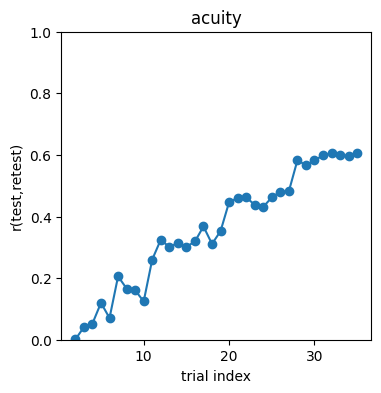

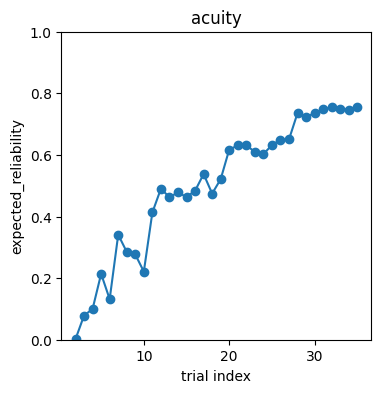

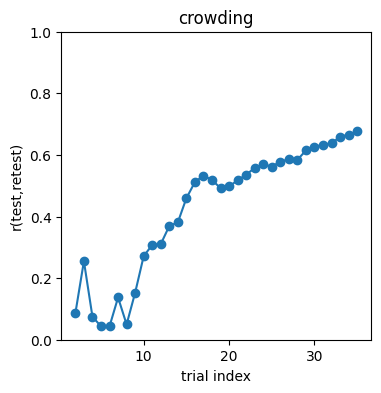

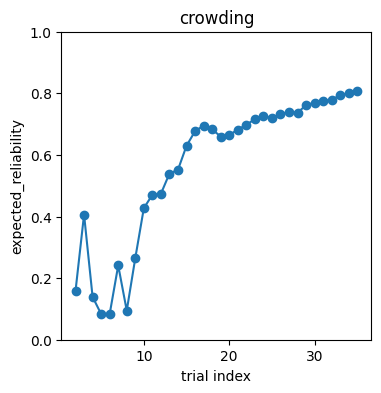

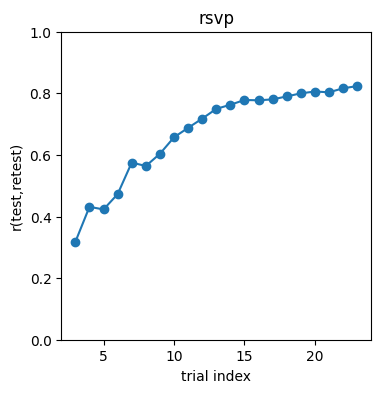

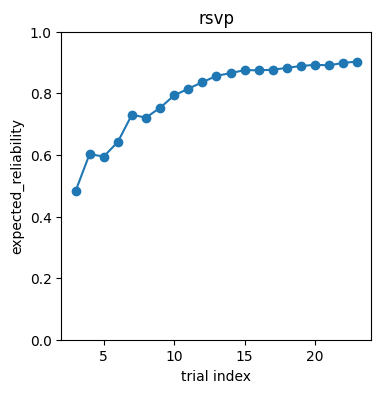

In [35]:
plot_reliability(rel_acuity, "acuity", "r(test,retest)")
plot_reliability(rel_acuity, "acuity", "expected_reliability")

plot_reliability(rel_crowding, "crowding", "r(test,retest)")
plot_reliability(rel_crowding, "crowding", "expected_reliability")

plot_reliability(rel_rsvp, "rsvp", "r(test,retest)")
plot_reliability(rel_rsvp, "rsvp", "expected_reliability")

# Sanity check

In [36]:
tt = pd.read_csv('tidy_both_sessions_thresholds_log.csv')

In [37]:
tt = tt[tt['taskName'] == 'rsvp']

num_trials_required = 24  # 24 trials for original staircase

rsvp_low_trial_ids = (
    tt.loc[
        tt["taskName"].isin(["rsvp"]) & (tt["numTrialsSent"] < num_trials_required),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < {num_trials_required}: {len(rsvp_low_trial_ids)}')

tt = tt[
    ~(
        (tt["taskName"] == "rsvp")
        & (tt["prolificID"].isin(rsvp_low_trial_ids))
    )
].copy()

tt = tt[['prolificID', 'repeat', 'threshold']]
tt_wide = (
    tt
    .pivot_table(index=['prolificID'],
                 columns='repeat',
                 values='threshold')
    .reset_index()
)
test = tt_wide.drop(columns='prolificID')
summarize_task(test)

Number of participants with at least 1 threshold with number of trials < 24: 0


within_subj_variance    0.039204
btw_subj_variance       0.059411
mean                    3.163056
r(test,retest)          0.504108
expected_reliability    0.670308
dtype: float64